In [1]:
from bmllData.bar.barBatchData import barBatchData
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from usefulTool.datetimeTool import get_trade_date_range
import numpy as np
import matplotlib.pyplot as plt

## Our dataset

In [2]:
temp = pd.read_parquet('/data/other_data/bar_data_56_tickers.parquet.gzip')

In [3]:
temp.shape

(56704988, 20)

In [4]:
dfA = pd.read_parquet('jiahong/prediction_0.parquet')

for i in range(1, 42):
    dfB = pd.read_parquet('jiahong/prediction_{}.parquet'.format(i))
    dfA.update(dfB)
    non_overlapping_rows = dfB[~dfB.index.isin(dfA.index)]
    dfA = pd.concat([dfA, non_overlapping_rows])

In [5]:
stacked_df = dfA.stack()

# Swap the level of the index to make the original columns as the first level
multi_index_df = stacked_df.swaplevel(0, 1)

# Sort the index
multi_index_df = multi_index_df.sort_index()

multi_index_df = multi_index_df.to_frame(name='pred_close')

In [6]:
def shift_within_group(group):
    return group.shift(-36)  # Replace 29 with your desired shift value

# Group by the first level of the index and apply the function
multi_index_df['pred_close_shift'] = multi_index_df.groupby(level=0)['pred_close'].apply(shift_within_group)

/tmp/ipykernel_4087373/1732858635.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  multi_index_df['pred_close_shift'] = multi_index_df.groupby(level=0)['pred_close'].apply(shift_within_group)


In [7]:
temp_close = temp[['close']]

In [8]:
temp_close = temp_close.loc[pd.IndexSlice[:, dfA.index[0]:dfA.index[-1]], :]

In [9]:
temp_close['close_shift'] = temp_close.groupby(level=0)['close'].apply(shift_within_group)

/tmp/ipykernel_4087373/950199368.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  temp_close['close_shift'] = temp_close.groupby(level=0)['close'].apply(shift_within_group)


In [10]:
new_df = pd.merge(multi_index_df, temp_close, left_index=True, right_index=True, how='inner')

In [11]:
new_df['return'] = new_df['close_shift']/new_df['close']
new_df['pred_return'] = new_df['pred_close_shift']/new_df['close']
new_df['pred_pred_return'] = new_df['pred_close_shift']/new_df['pred_close']

In [12]:
new_df = new_df[['return', 'pred_return', 'pred_pred_return']]

In [13]:
new_df.corr()

,return,pred_return,pred_pred_return
return,1.000000,-0.011252,-0.012870
pred_return,-0.011252,1.000000,0.041072
pred_pred_return,-0.012870,0.041072,1.000000


In [14]:
t3 = pd.read_parquet("/data/target_agg/TimeBar-30-start_20151027-end_20201231-M1-780_M2-10/ticker_universe_56_overnight_False_future_36_bars_mid.parquet.gzip")
new_corr = pd.concat([new_df, t3], axis=1, join='inner')
new_corr.corr(numeric_only=True)

,return,pred_return,pred_pred_return,pred
return,1.000000,-0.013424,-0.017819,0.852131
pred_return,-0.013424,1.000000,0.044440,-0.010531
pred_pred_return,-0.017819,0.044440,1.000000,-0.008896
pred,0.852131,-0.010531,-0.008896,1.000000


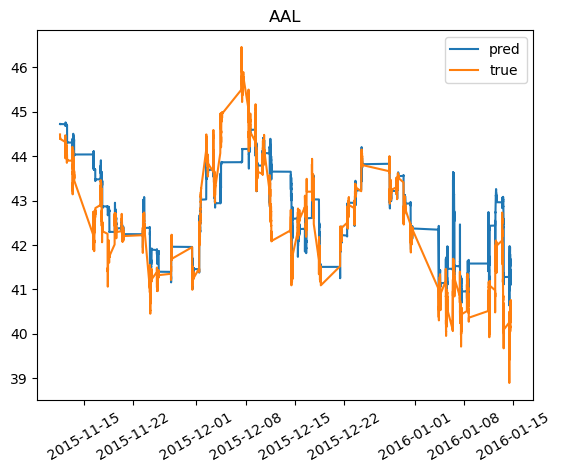

In [25]:
plt.plot(multi_index_df.loc[('AAL')]['pred_close'], label='pred')
plt.plot(temp_close.loc[('AAL')]['close'], label='true')
plt.legend()
plt.title('AAL')
plt.xticks(rotation=30)
plt.show()